

```
# Dataset Used - Cifar10

```
```
# Pretrained Model Used- Densenet169
```


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('GPU located at: {}'.format(device_name))
print('Tensorflow Version: {}'.format(tf.__version__))
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

GPU located at: /device:GPU:0
Tensorflow Version: 2.11.0
Number of GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import datasets, layers, models
%matplotlib inline

In [ ]:
def preprocess_data(X, Y):
    X = tf.keras.applications.densenet.preprocess_input(X)
    Y = tf.keras.utils.to_categorical(Y)
    return X, Y

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = preprocess_data(X_train, y_train)
x_test, y_test = preprocess_data(X_test, y_test)
X_train.shape

170498071/170498071 [==============================] - 14s 0us/step


(50000, 32, 32, 3)

In [ ]:
print('Training images: {}'.format(X_train.shape))
print('Testing images: {}'.format(X_test.shape))

Training images: (50000, 32, 32, 3)
Testing images: (10000, 32, 32, 3)


In [ ]:
#Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
initializer = tf.initializers.he_normal()
input = tf.keras.Input(shape=(32, 32, 3))
resized_images = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input)
model = tf.keras.applications.DenseNet169(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   classes=1000)
# Freezing each layer of the densenet169
for i in model.layers:
    i.trainable = False
output = model.layers[-1].output
flatten = tf.keras.layers.Flatten()
output = flatten(output)
layer_256 = tf.keras.layers.Dense(units=256,
                           activation='relu',
                           kernel_initializer=initializer,
                           kernel_regularizer=tf.keras.regularizers.l2())
output = layer_256(output)
dropout = tf.keras.layers.Dropout(0.5)
output = dropout(output)
softmax = tf.keras.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=tf.keras.regularizers.l2())
output = softmax(output)
model = tf.keras.models.Model(inputs=input, outputs=output)


51877672/51877672 [==============================] - 4s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['lambda[0][0]']                 
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                             

In [ ]:
model.compile(
         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [ ]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
checkpoint = tf.keras.callbacks.ModelCheckpoint('cifar10_densenet169.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(                                          
                                          horizontal_flip=True,                                        
                                          )
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(                                  
                                        horizontal_flip=True,                                        
                                        )
val_generator = val_datagen.flow(x_test, y_test, batch_size=32)
train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32
history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, checkpoint],
                    verbose=1)

Epoch 1/20
1562/1562 [==============================] - ETA: 0s - loss: 1.8704 - accuracy: 0.8192
Epoch 1: val_accuracy improved from -inf to 0.88942, saving model to cifar10_densenet169.h5
1562/1562 [==============================] - 254s 148ms/step - loss: 1.8704 - accuracy: 0.8192 - val_loss: 1.0185 - val_accuracy: 0.8894 - lr: 1.0000e-04
Epoch 2/20
1562/1562 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.8638
Epoch 2: val_accuracy improved from 0.88942 to 0.89443, saving model to cifar10_densenet169.h5
1562/1562 [==============================] - 222s 142ms/step - loss: 0.9401 - accuracy: 0.8638 - val_loss: 0.7383 - val_accuracy: 0.8944 - lr: 1.0000e-04
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.8720
Epoch 3: val_accuracy improved from 0.89443 to 0.89834, saving model to cifar10_densenet169.h5
1562/1562 [==============================] - 221s 142ms/step - loss: 0.7603 - accuracy: 0.8720 - val_loss: 0.6401 - 

In [ ]:
#train set accuracy
model.evaluate(X_train,y_train)   

1563/1563 [==============================] - 179s 114ms/step - loss: 0.7947 - accuracy: 0.7692


[0.7947070598602295, 0.7691799998283386]

In [ ]:
#test set accuracy
model.evaluate(X_test,y_test)  

313/313 [==============================] - 36s 115ms/step - loss: 0.8518 - accuracy: 0.7457


[0.8517927527427673, 0.7457000017166138]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save("/content/drive/MyDrive/cifar10__densenet169.h5")

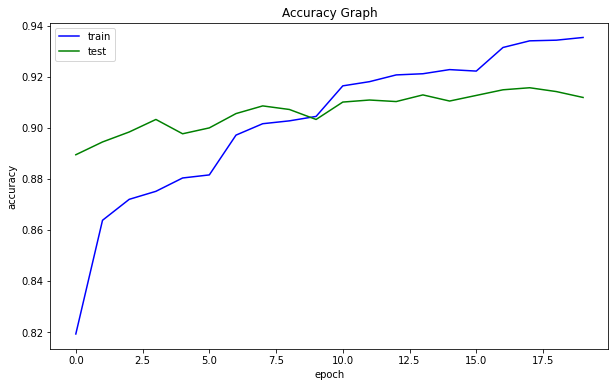

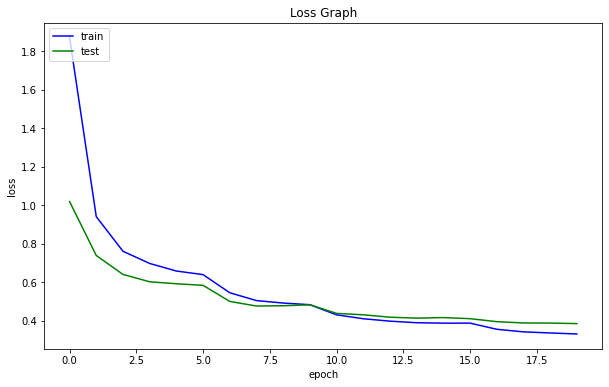

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'],'g')
plt.title('Accuracy Graph')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print("\n")

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title('Loss Graph')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()